In [18]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='WutjOE9uOQEHXlBlXOukDWKlQ6GXojOQ9y3STQ-dYc6U',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'powersystem-donotdelete-pr-7eocxjgqddq644'
object_key = 'fault_data.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_1 = pd.read_csv(body)
df_1.head(10)


,Fault ID,Fault Type,"Fault Location (Latitude, Longitude)",Voltage (V),Current (A),Power Load (MW),Temperature (°C),Wind Speed (km/h),Weather Condition,Maintenance Status,Component Health,Duration of Fault (hrs),Down time (hrs)
0,F001,Line Breakage,"(34.0522, -118.2437)",2200,250,50,25,20,Clear,Scheduled,Normal,2.0,1.0
1,F002,Transformer Failure,"(34.056, -118.245)",1800,180,45,28,15,Rainy,Completed,Faulty,3.0,5.0
2,F003,Overheating,"(34.0525, -118.244)",2100,230,55,35,25,Windstorm,Pending,Overheated,4.0,6.0
3,F004,Line Breakage,"(34.055, -118.242)",2050,240,48,23,10,Clear,Completed,Normal,2.5,3.0
4,F005,Transformer Failure,"(34.0545, -118.243)",1900,190,50,30,18,Snowy,Scheduled,Faulty,3.5,4.0
5,F006,Overheating,"(34.05, -118.24)",2150,220,52,32,22,Thunderstorm,Pending,Overheated,5.0,7.0
6,F007,Line Breakage,"(34.9449, -118.9839)",1994,233,51,23,21,Snowy,Completed,Normal,3.7,6.1
7,F008,Transformer Failure,"(34.2294, -118.2988)",2133,229,52,20,18,Snowy,Scheduled,Normal,5.4,2.1
8,F009,Line Breakage,"(34.1279, -118.8442)",2155,240,45,21,29,Rainy,Pending,Overheated,3.2,4.7
9,F010,Line Breakage,"(34.4192, -118.8254)",2065,199,55,25,21,Clear,Scheduled,Normal,4.0,2.8


In [19]:
# Part 2: Data Exploration

# Print columns and few rows to double-check
print(df_1.columns)
print(df_1.head())

# Basic info about dataset
print("Dataset info:")
print(df_1.info())

# Check for missing values
print("\nMissing values per column:")
print(df_1.isnull().sum())

# Statistical summary
print("\nStatistical summary:")
print(df_1.describe())

# Correct target column name with space
target_column = 'Fault Type'  

# Show unique values in the target column
print(f"\nUnique values in '{target_column}':")
print(df_1[target_column].unique())


Index(['Fault ID', 'Fault Type', 'Fault Location (Latitude, Longitude)',
       'Voltage (V)', 'Current (A)', 'Power Load (MW)', 'Temperature (°C)',
       'Wind Speed (km/h)', 'Weather Condition', 'Maintenance Status',
       'Component Health', 'Duration of Fault (hrs)', 'Down time (hrs)'],
      dtype='object')
  Fault ID           Fault Type Fault Location (Latitude, Longitude)  \
0     F001        Line Breakage                 (34.0522, -118.2437)   
1     F002  Transformer Failure                   (34.056, -118.245)   
2     F003          Overheating                  (34.0525, -118.244)   
3     F004        Line Breakage                   (34.055, -118.242)   
4     F005  Transformer Failure                  (34.0545, -118.243)   

   Voltage (V)  Current (A)  Power Load (MW)  Temperature (°C)  \
0         2200          250               50                25   
1         1800          180               45                28   
2         2100          230               55         

In [20]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Correct target column
target_column = 'Fault Type'

# Encode the target labels
le = LabelEncoder()
df_1['fault_label'] = le.fit_transform(df_1[target_column])

# Drop columns that won't be used as features or are targets
# Also drop Fault ID and Fault Type (target)
X = df_1.drop([target_column, 'fault_label', 'Fault ID'], axis=1, errors='ignore')

# If you want to drop 'Fault Location (Latitude, Longitude)' because it's complex:
X = X.drop(['Fault Location (Latitude, Longitude)'], axis=1, errors='ignore')

# Separate numeric and categorical columns
numeric_cols = ['Voltage (V)', 'Current (A)', 'Power Load (MW)', 'Temperature (°C)',
                'Wind Speed (km/h)', 'Duration of Fault (hrs)', 'Down time (hrs)']

categorical_cols = [col for col in X.columns if col not in numeric_cols]

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)

# Check for missing values
if X_encoded.isnull().sum().sum() > 0:
    X_encoded.fillna(X_encoded.mean(), inplace=True)

# Scale numeric columns only
scaler = StandardScaler()

# Scale the numeric columns in the encoded dataframe
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# Now X_encoded is your features matrix
X_scaled = X_encoded.values

y = df_1['fault_label']

print("Data preprocessing completed.")


Data preprocessing completed.


In [21]:
# Part 4: Train-Test Split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 404, Testing samples: 102



Training Support Vector Machine...
Support Vector Machine Accuracy: 0.4510
Classification Report:
                     precision    recall  f1-score   support

      Line Breakage       0.45      0.39      0.42        33
        Overheating       0.44      0.54      0.49        35
Transformer Failure       0.47      0.41      0.44        34

           accuracy                           0.45       102
          macro avg       0.45      0.45      0.45       102
       weighted avg       0.45      0.45      0.45       102



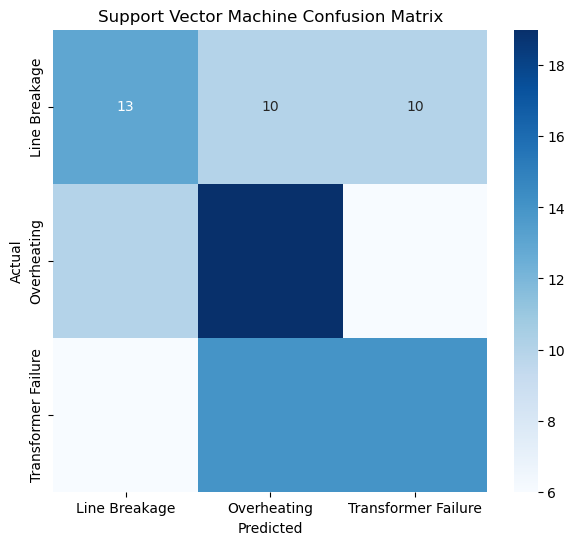


Training Random Forest...
Random Forest Accuracy: 0.3922
Classification Report:
                     precision    recall  f1-score   support

      Line Breakage       0.33      0.27      0.30        33
        Overheating       0.40      0.46      0.43        35
Transformer Failure       0.43      0.44      0.43        34

           accuracy                           0.39       102
          macro avg       0.39      0.39      0.39       102
       weighted avg       0.39      0.39      0.39       102



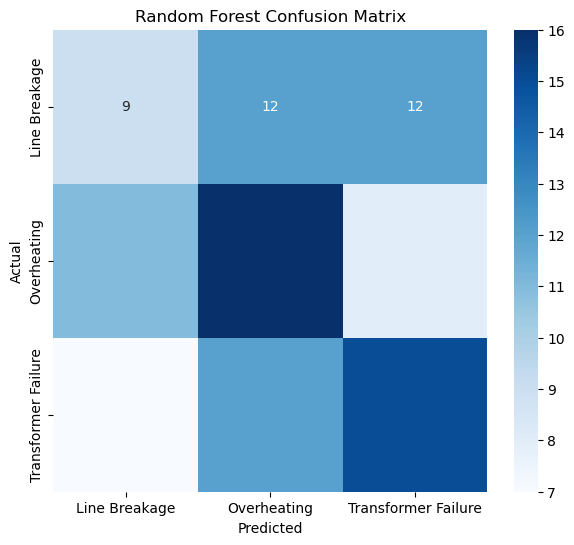

In [22]:
# Part 5: Model Training and Evaluation

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    'Support Vector Machine': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


In [23]:
# Part 6: Save Model and Scaler

import joblib

# Save the Random Forest model (or whichever you find best)
best_model = models['Random Forest']  # Change if you prefer SVM
joblib.dump(best_model, 'power_system_fault_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

print("Model and scaler saved!")


Model and scaler saved!
